In [1]:
######################
# Code for Diffusion Models
# Ref: https://github.com/dome272/Diffusion-Models-pytorch
######################

import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
from utils import *
import logging
from torch.utils.tensorboard import SummaryWriter

from modules import UNet_Conditional_VAE, EMA

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

In [2]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [3]:
def train(args):
    setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args) ; l = len(dataloader)
    model = UNet_Conditional_VAE(num_classes=args.num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    sample_img_freq = args.sample_img_freq
    
    try:
        ckpt_path = os.path.join("models", args.run_name, f"ckpt.pt")
        if device == "cuda": checkpoint = torch.load(ckpt_path)
        else: checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        logging.info(f"Resuming training from epoch: {start_epoch+1}")  
        if (start_epoch+1) >= args.epochs: 
            logging.info(f"No more epochs to train")
    except FileNotFoundError:
        start_epoch = -1
        loss = None
        logging.info("Starting training from scratch")

    for epoch in range(start_epoch+1, args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch*l+i)
            
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }
        torch.save(checkpoint, os.path.join("models", args.run_name, f"ckpt.pt"))
        
        if (epoch % sample_img_freq == 0) or (epoch + 1 == args.epochs):
            labels = torch.arange(10).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            plot_images(sampled_images)
            save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
            save_images(ema_sampled_images, os.path.join("results", args.run_name, f"{epoch}_ema.jpg"))

11:05:51 - INFO: Resuming training from epoch: 1
11:05:51 - INFO: Starting epoch 1:
100%|█████████████████████████████| 143/143 [00:18<00:00,  7.60it/s, MSE=0.0884]
11:06:22 - INFO: Starting epoch 2:
100%|█████████████████████████████| 143/143 [00:18<00:00,  7.67it/s, MSE=0.0526]
11:06:52 - INFO: Sampling 10 new images....
999it [01:50,  9.07it/s]
11:08:43 - INFO: Sampling 10 new images....
999it [01:50,  9.04it/s]


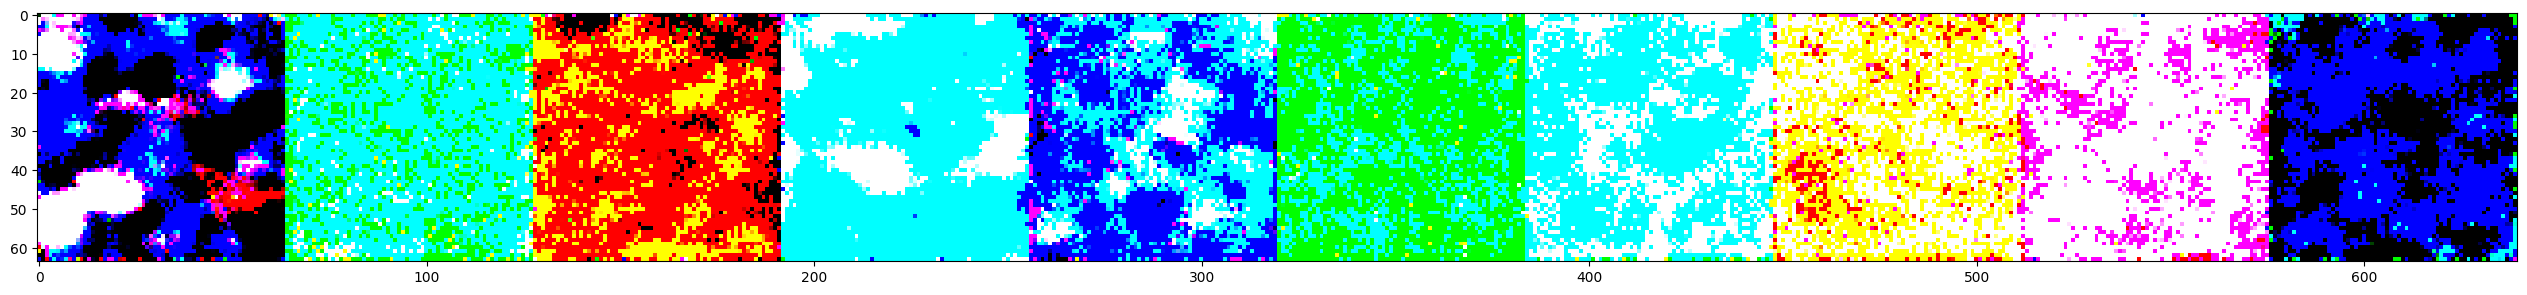

In [4]:
import argparse

class DDPMArgs:
    def __init__(self):
        pass
    
args = DDPMArgs()
args.run_name = "DDPM_conditional"
args.epochs = 3
args.batch_size = 7
args.image_size = 64
args.num_classes = 10
args.dataset_path = r"/vol/bitbucket/pn222/cifar10/cifar10-64/train"
args.device = "cuda"
args.lr = 3e-4
args.sample_img_freq = 5
args.experiment = True
args.subset_data = 1000

train(args)